In [25]:
import numpy as np
import random
import pandas as pd
from matplotlib import pylab as plt
import matplotlib.gridspec as gridspec

import sys
# %matplotlib inline
sys.path += ['../scripts/']

import labornet as lbn
# paths
path_data = "data/"
path_local = "../"
path_exp_sim = "../results/csv/"
path_exp_fig = "../results/fig/"

# variable that says if results are saved in csv or fig
save_csv =  True
save_fig = False
run_random = False
run_random_ret = True
# setting seed for reproducibility
np.random.seed(12345)
random.seed(12345)
# paths
path_data = "../data/"
path_local = "../"
path_exp_sim = "../results/csv/"

# simulation conditions
shock = "Covid"#"beveridgeCurve"
# shock = "SMLautomation"
file_occmobnet = "occupational_mobility_network.csv"

In [26]:
ipums_lab_file = "ipums_variables.csv"
ipums_covid = "ipums_variables_covid_only.csv"
df_labs = pd.read_csv(path_data + ipums_lab_file)
df_labs = pd.read_csv(path_data + ipums_lab_file)
wage = np.array(df_labs["log_median_earnings"])
ipums_employment2016 = "ipums_employment_2016.csv"
df_labs_emp = pd.read_csv(path_data+ipums_employment2016)
employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_whole_period"])

p = np.array(df_labs["auto_prob_average"])
df_covid = pd.read_csv(path_data + ipums_covid)
shock_covid = np.array(df_covid["shocks_pos"])
df_covid = pd.read_csv(path_data + ipums_covid)
shock_dampening = 1 - 0.5#1-1/3#1 - 0.1#1 - 1/3
shock_covid = shock_dampening * shock_covid * np.where(shock_covid < 0, 1, 0) + \
    shock_covid * np.where(shock_covid > 0, 1, 0)

In [27]:
print(sum(employment * (1 + shock_covid))/employment.sum())
# note it is different from 20% shock due to noise in the mapping, 
# one uses onet employment the other ipums employment

0.906368561456581


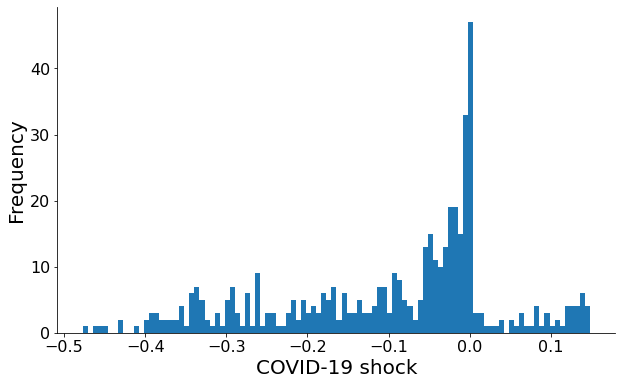

In [28]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
fontsize_ticks = 16#16
fontsize_axis = 20#34#26
fontsize_title = 28
fontsize_legend = 20
plt.hist(shock_covid, bins=100)
plt.xlabel("COVID-19 shock", fontsize=fontsize_axis)
plt.ylabel("Frequency", fontsize=fontsize_axis)
plt.tick_params(labelsize=fontsize_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(path_exp_fig + "Covid_Shock_historgram.png")
plt.show()

In [29]:
def covid_restructure(D_0, shock_covid):
    return D_0 * (1 + shock_covid)

In [30]:
# employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_2016"])
if shock == "FO_automation":
    p = np.array(df_labs["auto_prob_average"])
elif shock == "SMLautomation":
    p = np.array(df_sml['mSML'])/5

δ_u = 0.016 + 0.00000001 # adding zeros since useful for defining names
δ_v = 0.012 + 0.00000001
γ_u = 10*δ_u
γ_v = γ_u
parameters = [δ_u, δ_v, γ_u, γ_v]
τ = 3 # the one is due to python starting to count until 0
r = 0.5502916755953751
# fraction of labor force with which to run solution (to align with simulation)
diminishing_factor = 1.0#0.01#1.0

# occupational mobility network
A_omn = np.genfromtxt(path_data + file_occmobnet, delimiter=',')
n = A_omn.shape[0]
# complete network
A_kn = np.ones([n,n])/n

# shock and time conditions
t_shock = 100 # time at which shock starts
t_simulation = 400
shock_duration_years = 1
shock_duration = shock_duration_years * 52/6.75 # NOTE one time step ~6.75 weeks
time_array = [t*6.75/52 for t in range(t_simulation)]
t_steady_start = 25
t_steady_end = 75
# for sharp shocks
# t_transition_start = int(t_shock + 0.25*shock_duration)
# t_transition_end = int(t_shock + 0.75*shock_duration)
t_transition_start = int(t_shock +0*shock_duration) + int(1 * 52/6.75)
t_transition_end = int(t_shock + 1*shock_duration) + int(1 * 52/6.75)

# get demand in sigmoid
sigmoid_half_life, k = lbn.calibrate_sigmoid(shock_duration)

employment_0 = employment[:]
unemployment_0 = δ_u * employment_0
vacancies_0 = δ_v * employment_0
variables_0 = [employment_0, unemployment_0, vacancies_0]
# labor force is all workers, employed + unemployed
L = np.sum(employment_0 + unemployment_0)

# initial demand and target demand
D_0 = employment_0 + unemployment_0
# set random automation probabilities
# D_f = lbn.labor_restructure(D_0, p)
D_f = covid_restructure(D_0, shock_covid)

parameter_names = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
    "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ)) + "_shockduration" + \
    str(shock_duration_years) + "_dimfact" + str(diminishing_factor)[2:]



def lt_unemployment(U_all, τ):
    """ takes the array of all unemployment spells and with tau gives
    array with number of long term unemployed as defined by τ threshold
    """
    U_lt = u_longterm_from_jobspell(U_all, τ)
    # the -1 in tau is due to python counting starting on 0
    lt_unemployment = np.sum(U_all[:, τ:, :], axis=1)
    return lt_unemployment

# TODO check tau numbering and change in labornet in case needed
def u_longterm_from_jobspell(U_ltm, τ):
    # NOTE -1 since python starts counting on 1
    return np.sum(U_ltm[:, τ:, :], axis=1)

def save_result(Variables, U_all, D, τ, matrix, params=parameter_names, shock=shock):
    """Function that saves unemployment, vacnacies, employment, longterm unep,
    and demand into csv files
    """
    E, U, V = Variables
    names = ["u_per_occ_num","v_per_occ_num", "e_per_occ_num", \
            "ddagger_per_occ_num", "ltu_per_occ_num"]
    U_longterm = lt_unemployment(U_all, τ)
    for i, array in enumerate([U, V, E, D, U_longterm]):
        df = pd.DataFrame()
        df["id"] = np.arange(0, 464)
        df["label"] = df_labs["label"]
        for t in range(t_simulation):
            df["t" + str(t)] = array[t, :]
        df.to_csv(path_exp_sim + names[i] + matrix + shock + params+ "damp_" + str(shock_dampening)[2:3] + ".csv" )
    print("saving file " + path_exp_sim + names[0] + matrix + shock + params + "damp_" + str(shock_dampening)[2:3]+ ".csv")

def save_percentage_change(Variables, U_all, τ, t_steady_start, t_steady_end, \
    t_transition_start, t_transition_end, matrix, params=parameter_names, \
        shock=shock):
    """Function that computes percentage change in unemployment and longterm
    unemployment. For steady state averages u and ltu from steady start to
    steady end
    """
    E, U, V = Variables
    U_lt = u_longterm_from_jobspell(U_all, τ)
    u_perc_change_num = lbn.percentage_change_u(E, U, t_steady_start, \
                t_steady_end, t_transition_start, t_transition_end)
    ltu_perc_change_num = lbn.percentage_change_ltu(E, U, U_lt, \
                t_steady_start, t_steady_end, t_transition_start, t_transition_end)
    df = pd.DataFrame()
    df["id"] = np.arange(0, 464)
    df["label"] = df_labs["label"]
    df["u_perc_change"] = u_perc_change_num
    df["ltu_perc_change"] = ltu_perc_change_num
    df.to_csv(path_exp_sim + "u_ltu_perc_change" + matrix + shock + params+"damp_" + str(shock_dampening)[2:3] + ".csv" )
    print("saving file "+ path_exp_sim + "u_ltu_perc_change" + matrix + shock + params+ "damp_" + str(shock_dampening)[2:3] +".csv")




**bug with initial conditions means they cells should not be run consecutively but kernel restarted and then run**

In [31]:
# # run and save model for kn
# Variables_kn, U_all_kn, D_kn = lbn.run_numerical_solution(\
#     lbn.fire_and_hire_workers, t_simulation, parameters,\
#     variables_0, \
#     lbn.target_demand_automation, D_0, D_f, t_shock, k, sigmoid_half_life, \
#     lbn.matching_probability, A_kn, τ)

# save_result(Variables_kn, U_all_kn, D_kn, τ, "kn")
# save_percentage_change(Variables_kn, U_all_kn, τ, t_steady_start, t_steady_end, \
#     t_transition_start, t_transition_end, "kn")


In [32]:
employment_0 = employment[:]
unemployment_0 = δ_u * employment_0
vacancies_0 = δ_v * employment_0
variables_0 = [employment_0, unemployment_0, vacancies_0]

# run and save model for OMN
Variables_omn, U_all_omn, D_omn = lbn.run_numerical_solution(\
    lbn.fire_and_hire_workers, t_simulation, parameters,\
    variables_0, \
    lbn.target_demand_automation, D_0, D_f, t_shock, k, sigmoid_half_life, \
    lbn.matching_probability, A_omn, τ)

save_result(Variables_omn, U_all_omn, D_omn, τ, "OMN")
save_percentage_change(Variables_omn, U_all_omn, τ, t_steady_start, t_steady_end, \
    t_transition_start, t_transition_end, "OMN")

saving file ../results/csv/u_per_occ_numOMNCovid_deltau160v120gamma160_tau3_shockduration1_dimfact0damp_5.csv
saving file ../results/csv/u_ltu_perc_changeOMNCovid_deltau160v120gamma160_tau3_shockduration1_dimfact0damp_5.csv


In [17]:
 t_steady_start

25

In [18]:
t_steady_end

75

In [19]:
t_transition_start

107

In [20]:
t_transition_end

114

In [33]:
U_lt = u_longterm_from_jobspell(U_all_omn, τ)

In [34]:
ltu_pc = lbn.percentage_change_ltu(Variables_omn[0], Variables_omn[1], U_lt, \
                t_steady_start, t_steady_end, t_transition_start, t_transition_end)

In [35]:
max(ltu_pc) 

2505.2303804121175

In [ ]:
Variables_kn

In [17]:
Variables_omn[1]

array([[2.46313471e+04, 1.54774870e+04, 1.08936805e+03, ...,
        3.75954020e+02, 1.50659578e+03, 8.47781604e+02],
       [3.76612465e+04, 2.33218961e+04, 1.71655688e+03, ...,
        5.83351372e+02, 2.33674310e+03, 1.30778829e+03],
       [4.59707877e+04, 2.79675667e+04, 2.07789116e+03, ...,
        7.04013223e+02, 2.82679706e+03, 1.57606463e+03],
       ...,
       [4.40007860e+05, 2.20831666e+05, 9.38541948e+03, ...,
        1.61770799e+03, 1.48074799e+04, 6.55851479e+03],
       [4.40019569e+05, 2.20831908e+05, 9.38554664e+03, ...,
        1.61761457e+03, 1.48061821e+04, 6.55798178e+03],
       [4.40031034e+05, 2.20832134e+05, 9.38567104e+03, ...,
        1.61752282e+03, 1.48049077e+04, 6.55745845e+03]])